## Métodos de Eliminação Gaussiana e LU


#### Código

Início dos testes...
Dimensão n=10: Gauss = 8.689e-05 s, LU = 9.826e-05 s
Dimensão n=20: Gauss = 3.247e-04 s, LU = 3.496e-04 s
Dimensão n=30: Gauss = 9.486e-04 s, LU = 1.009e-03 s
Dimensão n=40: Gauss = 3.407e-03 s, LU = 3.307e-03 s
Dimensão n=50: Gauss = 3.765e-03 s, LU = 4.242e-03 s
Dimensão n=75: Gauss = 1.322e-02 s, LU = 1.341e-02 s
Dimensão n=100: Gauss = 2.949e-02 s, LU = 2.992e-02 s
Dimensão n=150: Gauss = 1.080e-01 s, LU = 1.004e-01 s
Dimensão n=200: Gauss = 2.592e-01 s, LU = 2.486e-01 s
Dimensão n=400: Gauss = 2.121e+00 s, LU = 2.071e+00 s
Dimensão n=800: Gauss = 1.960e+01 s, LU = 1.791e+01 s
Dimensão n=1600: Gauss = 1.464e+02 s, LU = 1.456e+02 s

Gerando gráfico dos tempos de execução...


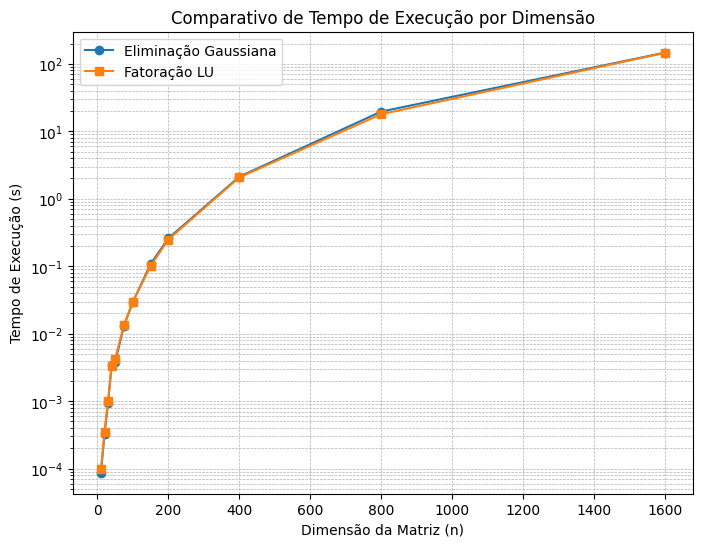

In [3]:
import time
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

# Tipos para maior clareza
Matrix = List[List[float]]
Vector = List[float]
Permutation = List[int]

# =============================================================================
# Funções Numéricas: Eliminação Gaussiana e Fatoração LU
# =============================================================================

def gaussian_factorize(matrix: Matrix) -> Tuple[Matrix, List[Tuple[int, int]]]:
    """
    Realiza a fatoração da matriz utilizando eliminação gaussiana com pivoteamento.

    Parâmetros:
      matrix: A matriz a ser fatorizada.

    Retorna:
      Uma tupla contendo:
        - A matriz fatorizada.
        - Uma lista de tuplas (pivot, linha_trocada) com as trocas realizadas.
    """
    n = len(matrix)
    # Cópia profunda para preservar a matriz original
    A = [row[:] for row in matrix]
    row_swaps: List[Tuple[int, int]] = []

    for pivot in range(n):
        max_row = pivot
        # Seleciona a linha com o maior valor absoluto na coluna do pivot
        for i in range(pivot, n):
            if abs(A[i][pivot]) > abs(A[max_row][pivot]):
                max_row = i

        # Realiza a troca se for necessário
        if max_row != pivot:
            row_swaps.append((pivot, max_row))
            A[pivot], A[max_row] = A[max_row], A[pivot]

        if abs(A[pivot][pivot]) < 1e-10:
            raise ValueError("Matriz singular.")

        # Eliminação dos termos abaixo do pivot
        for row in range(pivot + 1, n):
            factor = A[row][pivot] / A[pivot][pivot]
            A[row][pivot] = factor
            for col in range(pivot + 1, n):
                A[row][col] -= factor * A[pivot][col]

    return A, row_swaps

def gaussian_solve(factored_matrix: Matrix, row_swaps: List[Tuple[int, int]], b: Vector) -> Vector:
    """
    Resolve o sistema linear utilizando a matriz previamente fatorizada pela eliminação gaussiana.

    Parâmetros:
      factored_matrix: Matriz fatorizada obtida via gaussian_factorize.
      row_swaps: Lista de trocas de linhas realizadas durante a fatoração.
      b: Vetor do lado direito do sistema.

    Retorna:
      Vetor solução x.
    """
    n = len(factored_matrix)
    b_modified = b[:]  # Cópia do vetor b

    # Reaplica as trocas no vetor b
    for pivot, max_row in row_swaps:
        b_modified[pivot], b_modified[max_row] = b_modified[max_row], b_modified[pivot]

    # Substituição progressiva
    for pivot in range(n):
        for row in range(pivot + 1, n):
            b_modified[row] -= factored_matrix[row][pivot] * b_modified[pivot]

    # Substituição regressiva
    x: Vector = [0.0] * n
    for i in range(n - 1, -1, -1):
        x[i] = b_modified[i]
        for j in range(i + 1, n):
            x[i] -= factored_matrix[i][j] * x[j]
        x[i] /= factored_matrix[i][i]

    return x

def lu_factorize(matrix: Matrix) -> Tuple[Permutation, Matrix, Matrix]:
    """
    Realiza a fatoração LU com pivoteamento parcial na matriz.

    Parâmetros:
      matrix: A matriz a ser fatorizada.

    Retorna:
      Uma tupla contendo:
        - P: Vetor de permutação.
        - L: Matriz triangular inferior com diagonais unitárias.
        - U: Matriz triangular superior.
    """
    n = len(matrix)
    U: Matrix = [row[:] for row in matrix]  # Cópia para U
    L: Matrix = [[1.0 if i == j else 0.0 for j in range(n)] for i in range(n)]
    P: Permutation = list(range(n))

    for pivot in range(n):
        max_row = pivot
        # Seleciona o pivot com maior módulo
        for i in range(pivot, n):
            if abs(U[i][pivot]) > abs(U[max_row][pivot]):
                max_row = i

        if max_row != pivot:
            # Troca as linhas em U
            U[pivot], U[max_row] = U[max_row], U[pivot]
            # Troca os elementos já processados em L
            for col in range(pivot):
                L[pivot][col], L[max_row][col] = L[max_row][col], L[pivot][col]
            # Atualiza o vetor de permutação
            P[pivot], P[max_row] = P[max_row], P[pivot]

        if abs(U[pivot][pivot]) < 1e-10:
            raise ValueError("Matriz singular.")

        # Eliminação para atualizar L e U
        for row in range(pivot + 1, n):
            factor = U[row][pivot] / U[pivot][pivot]
            L[row][pivot] = factor
            for col in range(pivot, n):
                U[row][col] -= factor * U[pivot][col]

    return P, L, U

def lu_solve(P: Permutation, L: Matrix, U: Matrix, b: Vector) -> Vector:
    """
    Resolve o sistema linear utilizando a fatoração LU com o vetor de permutação P.

    Parâmetros:
      P: Vetor de permutação.
      L: Matriz triangular inferior.
      U: Matriz triangular superior.
      b: Vetor do lado direito.

    Retorna:
      Vetor solução x.
    """
    n = len(L)
    # Aplica a permutação no vetor b
    pb = [b[pi] for pi in P]

    # Resolucão de Ly = Pb (substituição progressiva)
    y: Vector = [0.0] * n
    for i in range(n):
        y[i] = pb[i]
        for j in range(i):
            y[i] -= L[i][j] * y[j]

    # Resolucão de Ux = y (substituição regressiva)
    x: Vector = [0.0] * n
    for i in range(n - 1, -1, -1):
        x[i] = y[i]
        for j in range(i + 1, n):
            x[i] -= U[i][j] * x[j]
        x[i] /= U[i][i]

    return x

def verify_solution(matrix: Matrix, x: Vector, b: Vector, eps: float = 1e-8) -> bool:
    """
    Verifica se a solução x satisfaz o sistema linear (matrix * x == b) dentro da tolerância eps.

    Retorna:
      True, se a solução é correta; caso contrário, False.
    """
    n = len(matrix)
    for i in range(n):
        total = sum(matrix[i][j] * x[j] for j in range(n))
        if abs(total - b[i]) > eps:
            return False
    return True

# =============================================================================
# Gerador de Testes
# =============================================================================

def generate_diagonally_dominant_matrix(n: int) -> Tuple[Matrix, Vector]:
    """
    Gera uma matriz de dimensão n x n que é diagonalmente dominante e um vetor b aleatório.

    Cada elemento fora da diagonal é gerado aleatoriamente e o elemento da diagonal é ajustado
    para garantir a dominância.

    Parâmetros:
      n: Dimensão da matriz.

    Retorna:
      Uma tupla contendo a matriz e o vetor b.
    """
    matrix: Matrix = []
    b: Vector = []

    for i in range(n):
        row = []
        sum_off_diag = 0.0

        for j in range(n):
            if i == j:
                row.append(0.0)
            else:
                value = random.uniform(-10, 10)
                row.append(value)
                sum_off_diag += abs(value)

        # Ajusta o elemento da diagonal para garantir dominância
        row[i] = sum_off_diag + random.uniform(1, 10)
        matrix.append(row)
        b.append(random.uniform(-10, 10))

    return matrix, b

# =============================================================================
# Testes e Medição de Tempo
# =============================================================================

def run_tests() -> Tuple[List[int], List[float], List[float]]:
    """
    Executa os testes dos métodos de solução do sistema linear para diversas dimensões,
    mede os tempos de execução e verifica a precisão das soluções.

    Retorna:
      - Lista de dimensões testadas.
      - Tempos de execução para a eliminação gaussiana.
      - Tempos de execução para a fatoração LU.
    """
    dimensions = [10, 20, 30, 40, 50, 75, 100, 150, 200, 400, 800, 1600]
    times_gauss: List[float] = []
    times_lu: List[float] = []

    for n in dimensions:
        matrix, b = generate_diagonally_dominant_matrix(n)

        # Teste com Eliminação Gaussiana
        start = time.perf_counter()
        try:
            factored_matrix, row_swaps = gaussian_factorize(matrix)
            solution_gauss = gaussian_solve(factored_matrix, row_swaps, b)
        except ValueError as error:
            print(f"Erro na fatoração Gaussiana para n={n}: {error}")
            solution_gauss = None
        elapsed_gauss = time.perf_counter() - start
        times_gauss.append(elapsed_gauss)

        # Teste com Fatoração LU
        start = time.perf_counter()
        try:
            P, L, U = lu_factorize(matrix)
            solution_lu = lu_solve(P, L, U, b)
        except ValueError as error:
            print(f"Erro na fatoração LU para n={n}: {error}")
            solution_lu = None
        elapsed_lu = time.perf_counter() - start
        times_lu.append(elapsed_lu)

        # Verifica se as soluções estão corretas
        if solution_gauss is not None and not verify_solution(matrix, solution_gauss, b):
            print(f"Solução Gaussiana incorreta para n={n}.")
        if solution_lu is not None and not verify_solution(matrix, solution_lu, b):
            print(f"Solução LU incorreta para n={n}.")

        print(f"Dimensão n={n}: Gauss = {elapsed_gauss:.3e} s, LU = {elapsed_lu:.3e} s")

    return dimensions, times_gauss, times_lu

# =============================================================================
# Função Principal
# =============================================================================

def main() -> None:
    """
    Função principal que executa os testes e gera o gráfico comparativo dos tempos de execução.
    """
    print("Início dos testes...")
    dimensions, times_gauss, times_lu = run_tests()

    print("\nGerando gráfico dos tempos de execução...")
    plt.figure(figsize=(8, 6))
    plt.plot(dimensions, times_gauss, marker='o', linestyle='-', label='Eliminação Gaussiana')
    plt.plot(dimensions, times_lu, marker='s', linestyle='-', label='Fatoração LU')
    plt.xlabel('Dimensão da Matriz (n)')
    plt.ylabel('Tempo de Execução (s)')
    plt.title('Comparativo de Tempo de Execução por Dimensão')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Escala logarítmica para melhor visualização
    plt.show()

if __name__ == "__main__":
    main()


Início dos testes...
Dimensão n=10: Gauss = 9.584e-05 s, LU = 9.378e-05 s
Dimensão n=20: Gauss = 3.193e-04 s, LU = 3.548e-04 s
Dimensão n=30: Gauss = 8.964e-04 s, LU = 1.148e-03 s
Dimensão n=40: Gauss = 2.516e-03 s, LU = 2.961e-03 s
Dimensão n=50: Gauss = 3.894e-03 s, LU = 4.103e-03 s
Dimensão n=75: Gauss = 1.208e-02 s, LU = 1.341e-02 s
Dimensão n=100: Gauss = 2.821e-02 s, LU = 2.939e-02 s
Dimensão n=150: Gauss = 1.035e-01 s, LU = 1.115e-01 s
Dimensão n=200: Gauss = 5.833e-01 s, LU = 4.709e-01 s
Gerando gráfico dos tempos de execução...


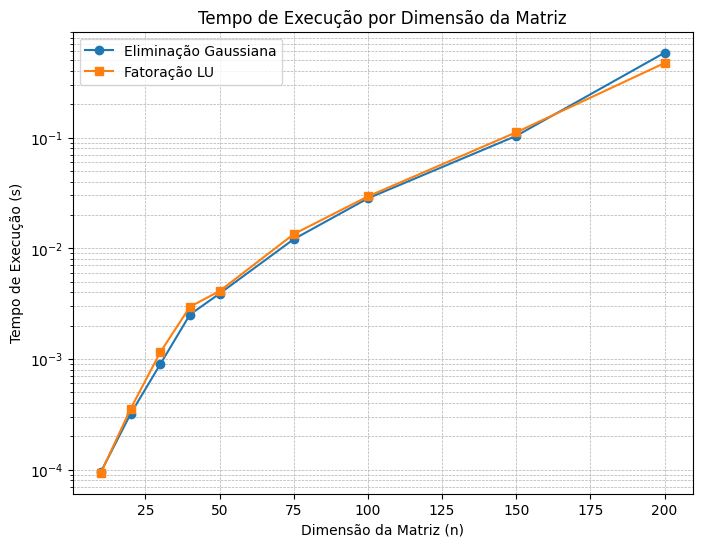

In [4]:
import time
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

# Tipos para maior clareza no código.
Matrix = List[List[float]]
Vector = List[float]
Permutation = List[int]

# =============================================================================
# Métodos de Eliminação Gaussiana e Fatoração LU
# =============================================================================

def gaussian_factorize(matrix: Matrix) -> Tuple[Matrix, List[Tuple[int, int]]]:
    """
    Realiza a fatoração da matriz utilizando eliminação gaussiana com pivoteamento.

    Parâmetros:
        matrix: A matriz a ser fatorizada.

    Retorna:
        Uma tupla contendo:
            - A matriz fatorizada (modificada).
            - Uma lista de tuplas (pivot, linha_trocada) que representa as trocas realizadas.
    """
    n = len(matrix)
    # Cria uma cópia profunda para não modificar a matriz original.
    A = [row[:] for row in matrix]
    row_swaps: List[Tuple[int, int]] = []

    for pivot in range(n):
        max_row = pivot
        # Seleciona a linha com o maior valor absoluto no pivot.
        for i in range(pivot, n):
            if abs(A[i][pivot]) > abs(A[max_row][pivot]):
                max_row = i

        # Realiza a troca de linhas se necessário.
        if max_row != pivot:
            row_swaps.append((pivot, max_row))
            A[pivot], A[max_row] = A[max_row], A[pivot]

        if abs(A[pivot][pivot]) < 1e-10:
            raise ValueError("Matrix is singular.")

        # Elimina os termos abaixo do pivot e armazena o fator.
        for row in range(pivot + 1, n):
            factor = A[row][pivot] / A[pivot][pivot]
            A[row][pivot] = factor
            for col in range(pivot + 1, n):
                A[row][col] -= factor * A[pivot][col]

    return A, row_swaps

def gaussian_solve(factored_matrix: Matrix, swaps: List[Tuple[int, int]], b: Vector) -> Vector:
    """
    Resolve o sistema linear utilizando a matriz previamente fatorizada pela eliminação gaussiana.

    Parâmetros:
        factored_matrix: A matriz fatorizada obtida por gaussian_factorize.
        swaps: Lista de trocas realizadas durante a fatoração.
        b: Vetor do lado direito.

    Retorna:
        Vetor solução x.
    """
    n = len(factored_matrix)
    b_modified = b[:]  # Faz uma cópia do vetor b.

    # Aplica as trocas realizadas na fatoração no vetor b.
    for pivot, max_row in swaps:
        b_modified[pivot], b_modified[max_row] = b_modified[max_row], b_modified[pivot]

    # Substituição progressiva: resolve L*y = b_modified.
    for pivot in range(n):
        for row in range(pivot + 1, n):
            b_modified[row] -= factored_matrix[row][pivot] * b_modified[pivot]

    # Substituição regressiva: resolve U*x = y.
    x: Vector = [0.0] * n
    for i in range(n - 1, -1, -1):
        x[i] = b_modified[i]
        for j in range(i + 1, n):
            x[i] -= factored_matrix[i][j] * x[j]
        x[i] /= factored_matrix[i][i]

    return x

def lu_factorize(matrix: Matrix) -> Tuple[Permutation, Matrix, Matrix]:
    """
    Realiza a fatoração LU com pivoteamento parcial na matriz.

    Parâmetros:
        matrix: A matriz a ser fatorizada.

    Retorna:
        Uma tupla contendo:
            - P: Vetor de permutação.
            - L: Matriz triangular inferior com diagonais unitárias.
            - U: Matriz triangular superior.
    """
    n = len(matrix)
    U: Matrix = [row[:] for row in matrix]
    L: Matrix = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        L[i][i] = 1.0
    P: Permutation = list(range(n))

    for pivot in range(n):
        max_row = pivot
        # Seleciona o pivot com maior valor absoluto para maior estabilidade.
        for i in range(pivot, n):
            if abs(U[i][pivot]) > abs(U[max_row][pivot]):
                max_row = i
        if max_row != pivot:
            # Troca as linhas em U.
            U[pivot], U[max_row] = U[max_row], U[pivot]
            # Troca os elementos já processados em L.
            for col in range(pivot):
                L[pivot][col], L[max_row][col] = L[max_row][col], L[pivot][col]
            # Atualiza o vetor de permutação.
            P[pivot], P[max_row] = P[max_row], P[pivot]

        if abs(U[pivot][pivot]) < 1e-10:
            raise ValueError("Matrix is singular.")

        # Atualiza L e U via eliminação.
        for row in range(pivot + 1, n):
            factor = U[row][pivot] / U[pivot][pivot]
            L[row][pivot] = factor
            for col in range(pivot, n):
                U[row][col] -= factor * U[pivot][col]

    return P, L, U

def lu_solve(P: Permutation, L: Matrix, U: Matrix, b: Vector) -> Vector:
    """
    Resolve o sistema linear dado pela fatoração LU, utilizando o vetor de permutação.

    Parâmetros:
        P: Vetor de permutação.
        L: Matriz triangular inferior.
        U: Matriz triangular superior.
        b: Vetor do lado direito.

    Retorna:
        Vetor solução x.
    """
    n = len(L)
    pb = [b[pi] for pi in P]  # Aplica a permutação no vetor b.

    # Solução intermediária: resolve L*y = pb pela substituição progressiva.
    y: Vector = [0.0] * n
    for i in range(n):
        y[i] = pb[i]
        for j in range(i):
            y[i] -= L[i][j] * y[j]

    # Substituição regressiva para resolver U*x = y.
    x: Vector = [0.0] * n
    for i in range(n - 1, -1, -1):
        x[i] = y[i]
        for j in range(i + 1, n):
            x[i] -= U[i][j] * x[j]
        x[i] /= U[i][i]

    return x

def verify_solution(matrix: Matrix, x: Vector, b: Vector, eps: float = 1e-8) -> bool:
    """
    Verifica se a solução x satisfaz o sistema linear matrix * x ≈ b dentro de uma tolerância.

    Parâmetros:
        matrix: Matriz do sistema.
        x: Vetor solução.
        b: Vetor do lado direito.
        eps: Tolerância para verificação (padrão 1e-8).

    Retorna:
        True se a solução estiver correta; caso contrário, False.
    """
    n = len(matrix)
    for i in range(n):
        total = sum(matrix[i][j] * x[j] for j in range(n))
        if abs(total - b[i]) > eps:
            return False
    return True

# =============================================================================
# Gerador de Testes
# =============================================================================

def generate_diagonally_dominant_matrix(n: int) -> Tuple[Matrix, Vector]:
    """
    Gera uma matriz n x n diagonalmente dominante e um vetor b.

    Cada elemento fora da diagonal é gerado aleatoriamente,
    e o elemento da diagonal é ajustado para garantir a dominância.

    Parâmetros:
        n: Dimensão da matriz.

    Retorna:
        Uma tupla contendo a matriz e o vetor b.
    """
    A: Matrix = []
    b: Vector = []

    for i in range(n):
        row = []
        sum_off_diag = 0.0
        for j in range(n):
            if i == j:
                row.append(0.0)
            else:
                value = random.uniform(-10, 10)
                row.append(value)
                sum_off_diag += abs(value)
        # Define o elemento diagonal como a soma dos valores absolutos dos demais
        # acrescido de um valor aleatório positivo.
        row[i] = sum_off_diag + random.uniform(1, 10)
        A.append(row)
        b.append(random.uniform(-10, 10))

    return A, b

# =============================================================================
# Testes e Medição de Tempo
# =============================================================================

def run_tests() -> Tuple[List[int], List[float], List[float]]:
    """
    Executa testes dos métodos de solução do sistema linear para diversas dimensões.

    Mede o tempo de execução dos métodos de eliminação gaussiana e fatoração LU,
    e verifica a precisão das soluções.

    Retorna:
        - Lista de dimensões testadas.
        - Lista de tempos de execução para a eliminação gaussiana.
        - Lista de tempos de execução para a fatoração LU.
    """
    dimensions = [10, 20, 30, 40, 50, 75, 100, 150, 200]
    times_gauss: List[float] = []
    times_lu: List[float] = []

    for n in dimensions:
        A, b = generate_diagonally_dominant_matrix(n)

        # Teste com Eliminação Gaussiana.
        start_time = time.perf_counter()
        try:
            A_fact, swaps = gaussian_factorize(A)
            x_gauss = gaussian_solve(A_fact, swaps, b)
        except ValueError as e:
            print(f"Erro para dimensão n={n} no método de Gauss: {e}")
            x_gauss = None
        elapsed_gauss = time.perf_counter() - start_time
        times_gauss.append(elapsed_gauss)

        # Teste com Fatoração LU.
        start_time = time.perf_counter()
        try:
            P, L, U = lu_factorize(A)
            x_lu = lu_solve(P, L, U, b)
        except ValueError as e:
            print(f"Erro para dimensão n={n} no método LU: {e}")
            x_lu = None
        elapsed_lu = time.perf_counter() - start_time
        times_lu.append(elapsed_lu)

        # Verifica a exatidão das soluções.
        if x_gauss is not None and not verify_solution(A, x_gauss, b):
            print(f"Solução Gaussiana incorreta para n={n}.")
        if x_lu is not None and not verify_solution(A, x_lu, b):
            print(f"Solução LU incorreta para n={n}.")

        print(f"Dimensão n={n}: Gauss = {elapsed_gauss:.3e} s, LU = {elapsed_lu:.3e} s")

    return dimensions, times_gauss, times_lu

# =============================================================================
# Função Principal
# =============================================================================

def main() -> None:
    """
    Função principal que executa os testes e gera o gráfico comparativo dos tempos de execução.
    """
    print("Início dos testes...")
    dimensions, times_gauss, times_lu = run_tests()

    print("Gerando gráfico dos tempos de execução...")
    plt.figure(figsize=(8, 6))
    plt.plot(dimensions, times_gauss, marker='o', linestyle='-', label='Eliminação Gaussiana')
    plt.plot(dimensions, times_lu, marker='s', linestyle='-', label='Fatoração LU')
    plt.xlabel("Dimensão da Matriz (n)")
    plt.ylabel("Tempo de Execução (s)")
    plt.title("Tempo de Execução por Dimensão da Matriz")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.yscale("log")  # Escala logarítmica para melhor visualização das diferenças
    plt.show()

if __name__ == "__main__":
    main()


## Método de Jacobi


Testando dimensão n = 10
Iteração   1: Norma do resíduo relativo = 2.824052e-01
Iteração   2: Norma do resíduo relativo = 8.504250e-02
Iteração   3: Norma do resíduo relativo = 2.348072e-02
Iteração   4: Norma do resíduo relativo = 6.564348e-03
Iteração   5: Norma do resíduo relativo = 2.645707e-03
Iteração   6: Norma do resíduo relativo = 9.448924e-04
Iteração   7: Norma do resíduo relativo = 2.512584e-04
Iteração   8: Norma do resíduo relativo = 9.781653e-05
Iteração   9: Norma do resíduo relativo = 3.471678e-05
Iteração  10: Norma do resíduo relativo = 8.305482e-06
Iteração  11: Norma do resíduo relativo = 3.945708e-06
Iteração  12: Norma do resíduo relativo = 1.071647e-06
Iteração  13: Norma do resíduo relativo = 3.425017e-07
Dimensão n = 10: 13 iterações, tempo = 4.435e-04 s, resíduo final = 3.43e-07

Testando dimensão n = 20
Iteração   1: Norma do resíduo relativo = 2.412422e-01
Iteração   2: Norma do resíduo relativo = 5.789871e-02
Iteração   3: Norma do resíduo relativo = 1.32

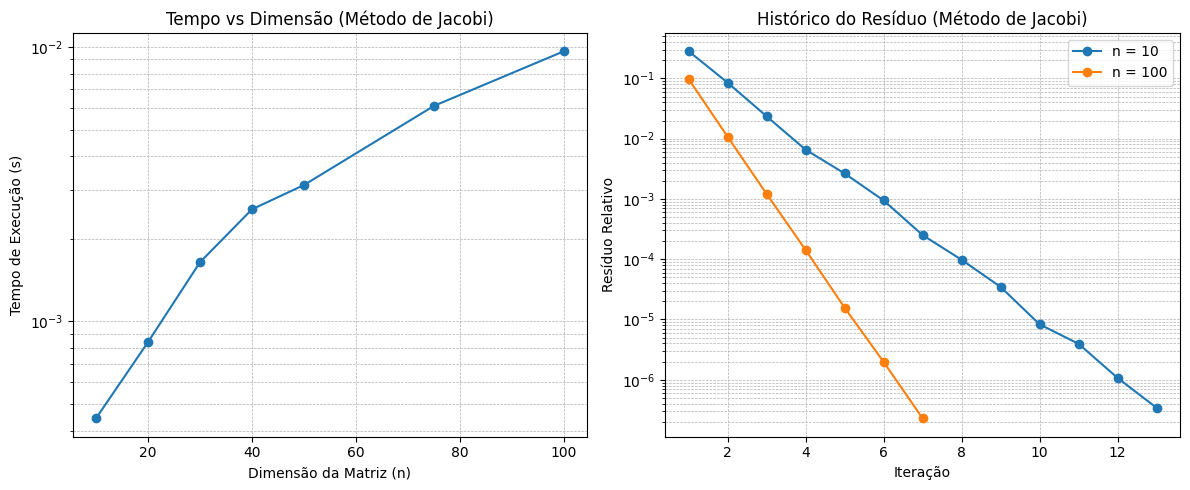

In [ ]:
import math
import random
import time
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

# Tipos para clareza
Matrix = List[List[float]]
Vector = List[float]

# =============================================================================
# Método de Jacobi (Implementação Pura)
# =============================================================================

def jacobi_method(A: Matrix, b: Vector, tol: float, max_iter: int) -> Tuple[Vector, List[float], int]:
    """
    Resolve iterativamente o sistema linear A*x = b utilizando o método de Jacobi.

    Parâmetros:
      A        : Matriz dos coeficientes (lista de listas).
      b        : Vetor dos termos independentes.
      tol      : Tolerância para o resíduo relativo para convergência.
      max_iter : Número máximo de iterações permitidas.

    Retorna:
      - x          : Vetor solução.
      - res_history: Lista contendo a norma do resíduo relativo em cada iteração.
      - num_iter   : Número de iterações realizadas.
    """
    n = len(A)
    # Chute inicial: vetor nulo
    x: Vector = [0.0] * n
    # Calcula a norma de b para usar no erro relativo
    norm_b = math.sqrt(sum(bi * bi for bi in b))
    if norm_b == 0:
        norm_b = 1.0  # Evita divisão por zero se b for o vetor zero
    res_history: List[float] = []

    for iteration in range(1, max_iter + 1):
        x_new: Vector = [0.0] * n
        # Atualiza x[i] isolando-o na i-ésima equação
        for i in range(n):
            sigma = 0.0
            for j in range(n):
                if j != i:
                    sigma += A[i][j] * x[j]
            # A[i][i] é diferente de zero em matrizes diagonalmente dominantes
            x_new[i] = (b[i] - sigma) / A[i][i]

        # Calcula o vetor resíduo r = b - A*x_new
        r = [b[i] - sum(A[i][j] * x_new[j] for j in range(n)) for i in range(n)]
        norm_r = math.sqrt(sum(ri * ri for ri in r))
        rel_error = norm_r / norm_b
        res_history.append(rel_error)
        print(f"Iteração {iteration:3d}: Norma do resíduo relativo = {rel_error:.6e}")
        if rel_error < tol:
            return x_new, res_history, iteration
        x = x_new  # Atualiza o chute
    return x, res_history, max_iter

# =============================================================================
# Gerador de Matrizes Diagonalmente Dominantes
# =============================================================================

def generate_diagonally_dominant_matrix(n: int) -> Tuple[Matrix, Vector]:
    """
    Gera uma matriz n x n diagonalmente dominante e um vetor b.

    Cada elemento fora da diagonal é gerado aleatoriamente e o elemento diagonal
    é definido como a soma dos valores absolutos dos demais elementos da linha,
    acrescido de um valor aleatório positivo.

    Parâmetros:
      n: Dimensão da matriz.

    Retorna:
      Uma tupla contendo a matriz gerada e o vetor b.
    """
    A: Matrix = []
    b: Vector = []

    for i in range(n):
        row: List[float] = []
        sum_off_diag = 0.0
        for j in range(n):
            if i == j:
                row.append(0.0)
            else:
                value = random.uniform(-10, 10)
                row.append(value)
                sum_off_diag += abs(value)
        # Define o elemento diagonal para garantir dominância
        row[i] = sum_off_diag + random.uniform(1, 10)
        A.append(row)
        b.append(random.uniform(-10, 10))

    return A, b

# =============================================================================
# Testes e Medição de Tempo
# =============================================================================

def run_tests() -> Tuple[List[int], List[float], Dict[int, List[float]]]:
    """
    Executa testes do método de Jacobi para diversas dimensões de matrizes,
    mede o tempo de execução e registra o histórico dos resíduos.

    Retorna:
      - dimensions   : Lista de dimensões testadas.
      - times        : Lista com o tempo de execução para cada dimensão.
      - res_histories: Dicionário que associa cada dimensão ao histórico do resíduo.
    """
    dimensions = [10, 20, 30, 40, 50, 75, 100]
    times: List[float] = []
    res_histories: Dict[int, List[float]] = {}

    for n in dimensions:
        A, b = generate_diagonally_dominant_matrix(n)
        print(f"\nTestando matriz de dimensão n = {n}")
        start_time = time.perf_counter()
        solution, res_history, iterations = jacobi_method(A, b, tol=1e-6, max_iter=500)
        elapsed_time = time.perf_counter() - start_time
        times.append(elapsed_time)
        res_histories[n] = res_history
        print(f"Dimensão n = {n}: {iterations} iterações, tempo = {elapsed_time:.3e} s, resíduo final = {res_history[-1]:.2e}")

    return dimensions, times, res_histories

# =============================================================================
# Plot dos Resultados: Tempo vs Dimensão e Histórico do Resíduo
# =============================================================================

def main() -> None:
    """
    Função principal que executa os testes e gera gráficos:
      1. Tempo de execução vs. dimensão da matriz.
      2. Histórico do resíduo relativo para duas dimensões representativas.
    """
    dimensions, times, res_histories = run_tests()

    # Cria figura com dois subplots
    plt.figure(figsize=(12, 5))

    # Subplot 1: Tempo de execução vs. dimensão
    plt.subplot(1, 2, 1)
    plt.plot(dimensions, times, marker='o', linestyle='-')
    plt.xlabel("Dimensão da Matriz (n)")
    plt.ylabel("Tempo de Execução (s)")
    plt.title("Tempo vs. Dimensão (Método de Jacobi)")
    plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Subplot 2: Histórico do resíduo para dimensões representativas
    plt.subplot(1, 2, 2)
    # Seleciona, por exemplo, a menor e a maior dimensão testada.
    for n in [dimensions[0], dimensions[-1]]:
        history = res_histories[n]
        iterations = list(range(1, len(history) + 1))
        plt.plot(iterations, history, marker='o', linestyle='-', label=f"n = {n}")
    plt.xlabel("Iteração")
    plt.ylabel("Resíduo Relativo")
    plt.title("Histórico do Resíduo (Método de Jacobi)")
    plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


## Resolvendo o sistema com Numpy

Dimensão 100: tempo = 2.834e-04 s
Dimensão 200: tempo = 3.457e-03 s
Dimensão 300: tempo = 2.407e-03 s
Dimensão 400: tempo = 4.773e-03 s
Dimensão 500: tempo = 8.188e-03 s
Dimensão 600: tempo = 1.528e-02 s
Dimensão 700: tempo = 2.073e-02 s
Dimensão 800: tempo = 3.596e-02 s
Dimensão 900: tempo = 4.155e-02 s
Dimensão 1000: tempo = 5.905e-02 s
Dimensão 2000: tempo = 3.655e-01 s


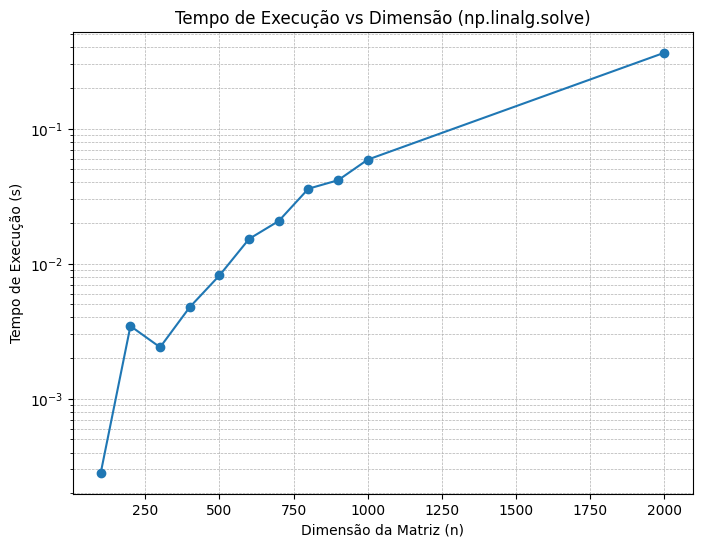

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Tuple, List

def generate_diagonally_dominant_matrix(n: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Gera uma matriz n x n diagonalmente dominante e um vetor b.

    Cada elemento fora da diagonal é gerado aleatoriamente no intervalo [-10, 10],
    e o elemento diagonal é definido como a soma dos valores absolutos da linha
    mais um valor aleatório positivo, garantindo a dominância.

    Parâmetros:
        n (int): Dimensão da matriz.

    Retorna:
        Tuple[np.ndarray, np.ndarray]: Uma tupla contendo a matriz A e o vetor b.
    """
    # Gera matriz aleatória
    A = np.random.uniform(-10, 10, (n, n))
    # Torna a matriz diagonalmente dominante
    for i in range(n):
        A[i, i] = np.sum(np.abs(A[i])) + np.random.uniform(1, 10)
    # Gera o vetor b aleatório
    b = np.random.uniform(-10, 10, n)
    return A, b

def measure_solve_times(dimensions: List[int]) -> Tuple[List[int], List[float]]:
    """
    Mede o tempo de execução da resolução do sistema linear A*x = b usando np.linalg.solve
    para diferentes dimensões de matrizes.

    Parâmetros:
        dimensions (List[int]): Lista das dimensões das matrizes a testar.

    Retorna:
        Tuple[List[int], List[float]]: Lista de dimensões e os respectivos tempos de execução.
    """
    execution_times: List[float] = []

    for n in dimensions:
        A, b = generate_diagonally_dominant_matrix(n)
        start_time = time.perf_counter()
        x = np.linalg.solve(A, b)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        execution_times.append(elapsed_time)
        print(f"Dimensão {n}: tempo = {elapsed_time:.3e} s")

    return dimensions, execution_times

def plot_execution_time(dimensions: List[int], times: List[float]) -> None:
    """
    Plota o gráfico de tempo de execução versus a dimensão da matriz.

    Parâmetros:
        dimensions (List[int]): Lista das dimensões testadas.
        times (List[float]): Tempo de execução para cada dimensão.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(dimensions, times, marker='o', linestyle='-')
    plt.xlabel("Dimensão da Matriz (n)")
    plt.ylabel("Tempo de Execução (s)")
    plt.title("Tempo de Execução vs Dimensão (np.linalg.solve)")
    plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

def main() -> None:
    """
    Função principal que executa os testes de desempenho e gera o gráfico do tempo de execução
    para a resolução de sistemas lineares com matrizes diagonalmente dominantes.
    """
    # Lista de dimensões a serem testadas
    dimensions = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]
    dims, execution_times = measure_solve_times(dimensions)
    plot_execution_time(dims, execution_times)

if __name__ == "__main__":
    main()



Dimensão n = 10
Pure Gaussian: tempo = 1.350e-04 s
Pure Jacobi: iterações = 12, tempo = 4.719e-04 s
NumPy linalg.solve: tempo = 4.049e-03 s
NumPy Jacobi: iterações = 12, tempo = 6.339e-04 s

Dimensão n = 20
Pure Gaussian: tempo = 5.996e-04 s
Pure Jacobi: iterações = 10, tempo = 1.410e-03 s
NumPy linalg.solve: tempo = 1.597e-04 s
NumPy Jacobi: iterações = 10, tempo = 3.527e-04 s

Dimensão n = 30
Pure Gaussian: tempo = 1.512e-03 s
Pure Jacobi: iterações = 10, tempo = 2.785e-03 s
NumPy linalg.solve: tempo = 2.491e-04 s
NumPy Jacobi: iterações = 10, tempo = 4.023e-04 s

Dimensão n = 40
Pure Gaussian: tempo = 2.960e-03 s
Pure Jacobi: iterações = 9, tempo = 3.029e-03 s
NumPy linalg.solve: tempo = 3.086e-04 s
NumPy Jacobi: iterações = 9, tempo = 3.540e-04 s

Dimensão n = 50
Pure Gaussian: tempo = 6.585e-03 s
Pure Jacobi: iterações = 8, tempo = 3.479e-03 s
NumPy linalg.solve: tempo = 3.053e-04 s
NumPy Jacobi: iterações = 8, tempo = 2.491e-04 s

Dimensão n = 75
Pure Gaussian: tempo = 1.403e-02

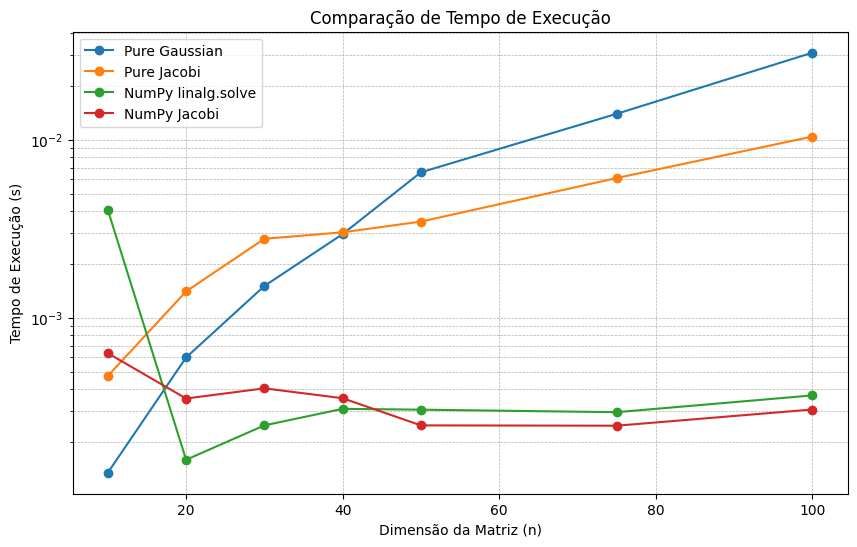

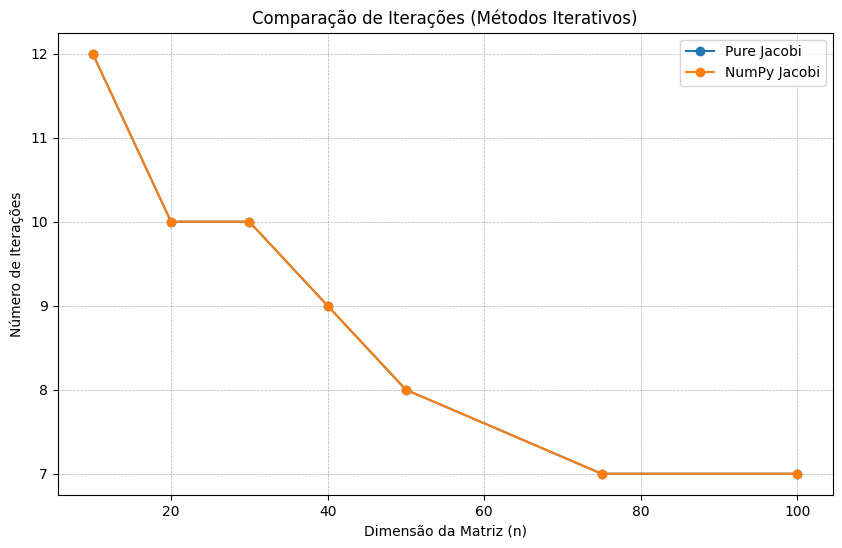

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

# =============================================================================
# Geração da Matriz Diagonalmente Dominante (utilizando NumPy)
# =============================================================================

def generate_diagonally_dominant_matrix(n: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Gera uma matriz n x n diagonalmente dominante e um vetor b.

    Cada elemento fora da diagonal é gerado aleatoriamente no intervalo [-10, 10],
    e o elemento diagonal é definido como a soma dos valores absolutos da linha
    acrescido de um valor aleatório positivo, garantindo a dominância.

    Parâmetros:
        n (int): Dimensão da matriz.

    Retorna:
        Tuple[np.ndarray, np.ndarray]: A matriz A e o vetor b.
    """
    A = np.random.uniform(-10, 10, (n, n))
    for i in range(n):
        A[i, i] = np.sum(np.abs(A[i])) + np.random.uniform(1, 10)
    b = np.random.uniform(-10, 10, n)
    return A, b

# =============================================================================
# Método de Eliminação Gaussiana (Python Puro com Listas)
# =============================================================================

def gaussian_factorize(matrix: List[List[float]]) -> Tuple[List[List[float]], List[Tuple[int, int]]]:
    """
    Fatora a matriz utilizando eliminação gaussiana com pivoteamento.

    Parâmetros:
      matrix: Matriz dos coeficientes representada como lista de listas.

    Retorna:
      Uma tupla contendo:
        - A matriz fatorizada.
        - Uma lista de tuplas (pivot, linha_trocada) com as trocas realizadas.
    """
    n = len(matrix)
    A = [row[:] for row in matrix]  # Cópia profunda
    row_swaps: List[Tuple[int, int]] = []

    for pivot in range(n):
        max_row = pivot
        for i in range(pivot, n):
            if abs(A[i][pivot]) > abs(A[max_row][pivot]):
                max_row = i
        if max_row != pivot:
            row_swaps.append((pivot, max_row))
            A[pivot], A[max_row] = A[max_row], A[pivot]
        if abs(A[pivot][pivot]) < 1e-10:
            raise ValueError("Matrix is singular.")
        for row in range(pivot + 1, n):
            factor = A[row][pivot] / A[pivot][pivot]
            A[row][pivot] = factor
            for col in range(pivot + 1, n):
                A[row][col] -= factor * A[pivot][col]
    return A, row_swaps

def gaussian_solve(factored_matrix: List[List[float]], swaps: List[Tuple[int, int]], b: List[float]) -> List[float]:
    """
    Resolve o sistema linear utilizando a fatoração gaussiana.

    Parâmetros:
      factored_matrix: Matriz fatorizada.
      swaps: Lista de trocas realizadas.
      b: Vetor do lado direito.

    Retorna:
      Vetor solução x.
    """
    n = len(factored_matrix)
    b_modified = b[:]  # Cópia do vetor b
    for pivot, max_row in swaps:
        b_modified[pivot], b_modified[max_row] = b_modified[max_row], b_modified[pivot]
    for pivot in range(n):
        for row in range(pivot + 1, n):
            b_modified[row] -= factored_matrix[row][pivot] * b_modified[pivot]
    x: List[float] = [0.0] * n
    for i in range(n - 1, -1, -1):
        x[i] = b_modified[i]
        for j in range(i + 1, n):
            x[i] -= factored_matrix[i][j] * x[j]
        x[i] /= factored_matrix[i][i]
    return x

def pure_gaussian_solver(A: List[List[float]], b: List[float]) -> List[float]:
    """
    Resolve Ax = b utilizando eliminação gaussiana pura.
    """
    A_fact, swaps = gaussian_factorize(A)
    return gaussian_solve(A_fact, swaps, b)

# =============================================================================
# Método Iterativo de Jacobi (Python Puro com Listas)
# =============================================================================

def jacobi_method(A: List[List[float]], b: List[float], tol: float, max_iter: int) -> Tuple[List[float], List[float], int]:
    """
    Resolve Ax = b iterativamente utilizando o método de Jacobi (listas em Python).

    Parâmetros:
      A        : Matriz dos coeficientes (lista de listas).
      b        : Vetor dos termos independentes.
      tol      : Tolerância para convergência do resíduo relativo.
      max_iter : Número máximo de iterações.

    Retorna:
      - x          : Vetor solução.
      - res_history: Histórico da norma do resíduo relativo em cada iteração.
      - num_iter   : Número de iterações realizadas.
    """
    n = len(A)
    x: List[float] = [0.0] * n
    norm_b = math.sqrt(sum(bi * bi for bi in b))
    if norm_b == 0:
        norm_b = 1.0
    res_history: List[float] = []

    for iteration in range(1, max_iter + 1):
        x_new = [0.0] * n
        for i in range(n):
            sigma = 0.0
            for j in range(n):
                if j != i:
                    sigma += A[i][j] * x[j]
            x_new[i] = (b[i] - sigma) / A[i][i]
        r = [b[i] - sum(A[i][j] * x_new[j] for j in range(n)) for i in range(n)]
        norm_r = math.sqrt(sum(ri * ri for ri in r))
        rel_error = norm_r / norm_b
        res_history.append(rel_error)
        if rel_error < tol:
            return x_new, res_history, iteration
        x = x_new
    return x, res_history, max_iter

# =============================================================================
# Método Iterativo de Jacobi (Vetorizado com NumPy)
# =============================================================================

def jacobi_numpy(A: np.ndarray, b: np.ndarray, tol: float, max_iter: int) -> Tuple[np.ndarray, List[float], int]:
    """
    Resolve Ax = b utilizando o método iterativo de Jacobi com operações vetorizadas do NumPy.

    Parâmetros:
      A        : Matriz dos coeficientes (np.ndarray).
      b        : Vetor dos termos independentes (np.ndarray).
      tol      : Tolerância para convergência.
      max_iter : Número máximo de iterações.

    Retorna:
      - x          : Vetor solução.
      - res_history: Histórico do resíduo relativo a cada iteração.
      - num_iter   : Número de iterações realizadas.
    """
    n = A.shape[0]
    x = np.zeros(n)
    norm_b = np.linalg.norm(b)
    if norm_b == 0:
        norm_b = 1.0
    res_history: List[float] = []

    D = np.diag(A)
    R = A - np.diagflat(D)

    for iteration in range(1, max_iter + 1):
        x_new = (b - R.dot(x)) / D
        r = b - A.dot(x_new)
        rel_error = np.linalg.norm(r) / norm_b
        res_history.append(rel_error)
        if rel_error < tol:
            return x_new, res_history, iteration
        x = x_new
    return x, res_history, max_iter

# =============================================================================
# Medição de Tempo e Comparação das Abordagens
# =============================================================================

def run_comparisons(dimensions: List[int], tol: float = 1e-6, max_iter: int = 500) -> Tuple[Dict[str, List[float]], Dict[str, List[int]]]:
    """
    Executa os métodos para diferentes dimensões e coleta os tempos de execução.

    Parâmetros:
      dimensions (List[int]): Lista de dimensões a serem testadas.
      tol (float): Tolerância para os métodos iterativos.
      max_iter (int): Número máximo de iterações para os métodos iterativos.

    Retorna:
      Dois dicionários:
        - times: tempos de execução para cada método.
        - iterations: número de iterações (para os métodos iterativos).
    """
    times: Dict[str, List[float]] = {
        "Pure Gaussian": [],
        "Pure Jacobi": [],
        "NumPy linalg.solve": [],
        "NumPy Jacobi": []
    }
    iterations: Dict[str, List[int]] = {
        "Pure Jacobi": [],
        "NumPy Jacobi": []
    }

    for n in dimensions:
        print(f"\nDimensão n = {n}")
        # Gerar matriz e vetor (usando NumPy)
        A_np, b_np = generate_diagonally_dominant_matrix(n)

        # Converter para listas para métodos em Python puro
        A_list = A_np.tolist()
        b_list = b_np.tolist()

        # Método 1: Pure Python Gaussian elimination
        start = time.perf_counter()
        try:
            sol_gauss = pure_gaussian_solver(A_list, b_list)
        except Exception as e:
            print(f"Erro no método Pure Gaussian para n = {n}: {e}")
            sol_gauss = None
        time_gauss = time.perf_counter() - start
        times["Pure Gaussian"].append(time_gauss)
        print(f"Pure Gaussian: tempo = {time_gauss:.3e} s")

        # Método 2: Pure Python Jacobi
        start = time.perf_counter()
        try:
            sol_jacobi, res_hist_jacobi, iter_jacobi = jacobi_method(A_list, b_list, tol, max_iter)
        except Exception as e:
            print(f"Erro no método Pure Jacobi para n = {n}: {e}")
            sol_jacobi, res_hist_jacobi, iter_jacobi = None, [], 0
        time_pure_jacobi = time.perf_counter() - start
        times["Pure Jacobi"].append(time_pure_jacobi)
        iterations["Pure Jacobi"].append(iter_jacobi)
        print(f"Pure Jacobi: iterações = {iter_jacobi}, tempo = {time_pure_jacobi:.3e} s")

        # Método 3: NumPy linalg.solve (solver direto)
        start = time.perf_counter()
        try:
            sol_np = np.linalg.solve(A_np, b_np)
        except Exception as e:
            print(f"Erro no método NumPy linalg.solve para n = {n}: {e}")
            sol_np = None
        time_np = time.perf_counter() - start
        times["NumPy linalg.solve"].append(time_np)
        print(f"NumPy linalg.solve: tempo = {time_np:.3e} s")

        # Método 4: NumPy Jacobi (vetorizado)
        start = time.perf_counter()
        try:
            sol_jacobi_np, res_hist_jacobi_np, iter_jacobi_np = jacobi_numpy(A_np, b_np, tol, max_iter)
        except Exception as e:
            print(f"Erro no método NumPy Jacobi para n = {n}: {e}")
            sol_jacobi_np, res_hist_jacobi_np, iter_jacobi_np = None, [], 0
        time_np_jacobi = time.perf_counter() - start
        times["NumPy Jacobi"].append(time_np_jacobi)
        iterations["NumPy Jacobi"].append(iter_jacobi_np)
        print(f"NumPy Jacobi: iterações = {iter_jacobi_np}, tempo = {time_np_jacobi:.3e} s")

    return times, iterations

def plot_comparisons(dimensions: List[int], times: Dict[str, List[float]]) -> None:
    """
    Plota os tempos de execução para os diferentes métodos em função da dimensão da matriz.
    """
    plt.figure(figsize=(10, 6))
    for method, t_list in times.items():
        plt.plot(dimensions, t_list, marker='o', linestyle='-', label=method)
    plt.xlabel("Dimensão da Matriz (n)")
    plt.ylabel("Tempo de Execução (s)")
    plt.title("Comparação de Tempo de Execução")
    plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

def plot_iterations(dimensions: List[int], iterations: Dict[str, List[int]]) -> None:
    """
    Plota o número de iterações necessários para os métodos iterativos (Jacobi) em função da dimensão.
    """
    plt.figure(figsize=(10, 6))
    for method, iter_list in iterations.items():
        plt.plot(dimensions, iter_list, marker='o', linestyle='-', label=method)
    plt.xlabel("Dimensão da Matriz (n)")
    plt.ylabel("Número de Iterações")
    plt.title("Comparação de Iterações (Métodos Iterativos)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

def main() -> None:
    # Dimensões de matrizes para testar
    dimensions = [10, 20, 30, 40, 50, 75, 100]
    # Executa os testes e coleta os tempos e iterações
    times, iterations = run_comparisons(dimensions, tol=1e-6, max_iter=500)
    # Plota os gráficos comparativos
    plot_comparisons(dimensions, times)
    plot_iterations(dimensions, iterations)

if __name__ == "__main__":
    main()
